In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue
import statsmodels.api as sm
from scipy import stats

from plastockmethods import name_the_zones, name_the_particles, frequentation_name, situation_name
from plastockmethods import particle_groups, name_the_substrate, name_the_distance, table_css_styles

def translate_describe(x, value_column):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    
    return df

work_data = pd.read_csv("data/end_pipe/long_form_micro.csv")
wide_form = pd.read_csv("data/end_pipe/aggregated_micro_results.csv")
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv")

wdx = work_data.copy()
wdx["position"] = wdx.position.apply(lambda x: name_the_zones[x])
wdx["frequentation"] = wdx.frequentation.apply(lambda x: frequentation_name[x])
wdx["situation"] = wdx.situation.apply(lambda x: situation_name[x])
wdx["distance"] = wdx.distance.apply(lambda x: name_the_distance[x])
wdx["substrat"] = wdx.substrat.apply(lambda x: name_the_substrate[x])

# Autres modèles linéaires

La position des échantillons sur la plage (ligne d'eau, plage-seche) représente différentes conditions d'échantillonnage. C'est pourquoi nous les traiterons séparément.

Les fragments durs et souple sont combinés pour chaque échantillon.

## Ligne d'eau

In [2]:
caption = "Les données sont regroupées en deux groupes par échantillon: 1. fibres, 2. fragment."

# separate the first zone
wdi = wdx[wdx.position == "ligne-d'eau"].copy()
scaled = (wdi["compte"] - wdi["compte"].min()) / (wdi["compte"].max() - wdi["compte"].min())
# wdi["scaled"] = scaled

# wdi["const"] = 1.0

# columns of interest
x_cols = ["orientation", "substrat", "frequentation", "situation", "distance", "objet"]
y_col = ["compte"]

# combine the fragments
w_f = wdi[wdi.objet.isin(["souple", "fdure"])].copy()

souple_d = w_f.groupby(["echantillon", *x_cols[:-1]], as_index=False).compte.sum()
souple_d["objet"] = "fragment"

# isolate the fibres
fibres = wdi[wdi.objet.isin(["fibres"])].copy()

# combine the aggregate fragments and the fibres
w_d = pd.concat([souple_d[[*x_cols, *y_col]], fibres[[*x_cols, *y_col]]])
w_d["scaled"] = (w_d.compte - w_d.compte.min())/(w_d.compte.max() - w_d.compte.min())


w_d.head().style.set_table_styles(table_css_styles).set_caption(caption)

,orientation,substrat,frequentation,situation,distance,objet,compte,scaled
0,NE,galet,élévée,campagne,< 100m,fragment,0,0.000000
1,NNE,galet,élévée,campagne,< 100m,fragment,15,0.023292
2,NE,galet,élévée,campagne,< 100m,fragment,0,0.000000
3,NNE,galet,élévée,campagne,< 100m,fragment,3,0.004658
4,NNO,galet,moyenne,campagne,< 100m,fragment,9,0.013975


## Gridsearch with PCA

In [3]:
# encode categorical
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.dummy import DummyRegressor

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(w_d)
print(categorical_columns)

w_dc = w_d[categorical_columns].copy()

['orientation', 'substrat', 'frequentation', 'situation', 'distance', 'objet']


In [4]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas")
w_dencoded = encoder.fit_transform(w_dc)
rmse = make_scorer(mean_squared_error, squared=False)
X_not_scale = w_dc
Y_not_scale = w_d.compte

### Cross validated results: mean squared error

In [5]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import make_column_transformer
model = Pipeline([
    ('scale', StandardScaler()),
    ('pca',PCA()),
    ('lm', Lasso())
])

param_grid = {
    'pca__n_components': [3, 5, 7],
    # 'lm__alpha': np.logspace(-3, 3, 5)
}

gscv = GridSearchCV(model, param_grid=param_grid, cv=10, scoring = rmse)

results = cross_validate(gscv, w_dencoded, Y_not_scale, cv=10, scoring = rmse, verbose=4)

gscv

[CV] END ......................................, score=69.833 total time=   0.2s
[CV] END ......................................, score=61.233 total time=   0.2s
[CV] END ....................................., score=118.265 total time=   0.2s
[CV] END ....................................., score=131.466 total time=   0.2s
[CV] END ......................................, score=57.558 total time=   0.2s
[CV] END ......................................, score=85.579 total time=   0.2s
[CV] END ......................................, score=38.895 total time=   0.2s
[CV] END ......................................, score=65.614 total time=   0.2s
[CV] END ......................................, score=73.920 total time=   0.2s
[CV] END ......................................, score=76.559 total time=   0.2s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('pca', PCA()), ('lm', Lasso())]),
             param_grid={'pca__n_components': [3, 5, 7]},
             scoring=make_scorer(mean_squared_error, squared=False))

## Linear regression, sklearn

In [6]:
from scipy.special import exp10
from sklearn.linear_model import BayesianRidge


def rev_min_max_func(scaled_val, df, column: str = "compte"):
    max_val = max(df[column])
    min_val = min(df[column])
    og_val = (scaled_val*(max_val - min_val)) + min_val
    return og_val

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary"), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

model = make_pipeline(
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=exp10
    ),
)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(w_dencoded, w_d.scaled, random_state=42)

ols = LinearRegression().fit(X_train, y_train)
predictions = ols.predict(X_train)

p_unscaled = [rev_min_max_func(x, w_d) for x in predictions]

In [7]:
ols

LinearRegression()

### Cross validated results: mean squared error

In [8]:
results_l = cross_validate(ols, X_train, y_train, cv=10, scoring = rmse, verbose=4)

[CV] END ......................................., score=0.085 total time=   0.0s
[CV] END ......................................., score=0.233 total time=   0.0s
[CV] END ......................................., score=0.081 total time=   0.0s
[CV] END ......................................., score=0.072 total time=   0.0s
[CV] END ..........................., score=6013520687107.255 total time=   0.0s
[CV] END ......................................., score=0.061 total time=   0.0s
[CV] END ......................................., score=0.108 total time=   0.0s
[CV] END ......................................., score=0.179 total time=   0.0s
[CV] END ......................................., score=0.109 total time=   0.0s
[CV] END ......................................., score=0.103 total time=   0.0s


## Bayesian ridge regression (L2)

Bayesian regression techniques can be used to include regularization parameters in the estimation procedure: the regularization parameter is not set in a hard sense but tuned to the data at hand.

This can be done by introducing uninformative priors over the hyper parameters of the model. The regularization used in Ridge regression and classification is equivalent to finding a maximum a posteriori estimation under a Gaussian prior over the coefficients with precision . Instead of setting lambda manually, it is possible to treat it as a random variable to be estimated from the data.

In [9]:
bayes = BayesianRidge(compute_score=True, max_iter=30).fit(X_train, y_train)
predictions_b = bayes.predict(X_train)

p_unscaled_b = [rev_min_max_func(x, w_d) for x in predictions_b]
bayes

BayesianRidge(compute_score=True, max_iter=30)

### Cross validated results: mean squared error

In [10]:
results_b = cross_validate(bayes, X_train, y_train, cv=10, scoring = rmse, verbose=4)

[CV] END ......................................., score=0.057 total time=   0.0s
[CV] END ......................................., score=0.229 total time=   0.0s
[CV] END ......................................., score=0.092 total time=   0.0s
[CV] END ......................................., score=0.075 total time=   0.0s
[CV] END ......................................., score=0.078 total time=   0.0s
[CV] END ......................................., score=0.053 total time=   0.0s
[CV] END ......................................., score=0.096 total time=   0.0s
[CV] END ......................................., score=0.184 total time=   0.0s
[CV] END ......................................., score=0.100 total time=   0.0s
[CV] END ......................................., score=0.094 total time=   0.0s


## Lasso (L1)

The primary goal of LASSO regression is to find a balance between model simplicity and accuracy. It achieves this by adding a penalty term to the traditional linear regression model, which encourages sparse solutions where some coefficients are forced to be exactly zero. This feature makes LASSO particularly useful for feature selection, as it can automatically identify and discard irrelevant or redundant variables.

In [11]:
import time
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

start_time = time.time()
lasso_cv = make_pipeline(StandardScaler(), LassoCV(cv=20)).fit(X_train, y_train)
fit_time = time.time() - start_time
lasso_cv.fit(X_train, y_train)
predictions_lcv = lasso_cv.predict(X_train)

lasso_cvp = [rev_min_max_func(x, w_d) for x in predictions_lcv]
lasso_cv

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv', LassoCV(cv=20))])

In [12]:
results_cv = cross_validate(lasso_cv, X_train, y_train, cv=10, scoring = rmse, verbose=4)

[CV] END ......................................., score=0.059 total time=   0.3s
[CV] END ......................................., score=0.230 total time=   0.3s
[CV] END ......................................., score=0.095 total time=   0.2s
[CV] END ......................................., score=0.081 total time=   0.3s
[CV] END ......................................., score=0.078 total time=   0.2s
[CV] END ......................................., score=0.052 total time=   0.3s
[CV] END ......................................., score=0.098 total time=   0.2s
[CV] END ......................................., score=0.193 total time=   0.2s
[CV] END ......................................., score=0.103 total time=   0.3s
[CV] END ......................................., score=0.089 total time=   0.3s


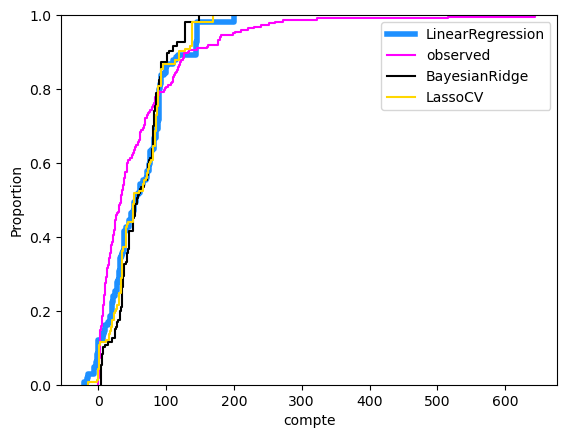

In [13]:
fig, ax = plt.subplots()

sns.ecdfplot(p_unscaled, ax=ax, label="LinearRegression", linewidth=4, color="dodgerblue")
sns.ecdfplot(w_d["compte"], label="observed", color="magenta", ax=ax)
sns.ecdfplot(p_unscaled_b, label="BayesianRidge", ax=ax, color="black")
sns.ecdfplot(lasso_cvp, label="LassoCV", ax=ax, color="gold")
ax.legend()

plt.show()

In [14]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: glm_p

statsmodels: 0.13.5
numpy      : 1.24.2
scipy      : 1.10.1
seaborn    : 0.12.2
pandas     : 2.0.0
matplotlib : 3.7.1

